# Reverse Autodiff


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [93]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0
        self._prev = set(_children) # previous nodes used for building the compute graph
        self._backward = lambda: None # backward prop function
        self._op = _op # operator from previous node to current node
        self.label = label # name of the node
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # chain rule for backpropagation
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self.__add__(other)
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        # chain rule for backpropagation
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supporting int or float"
        out = Value(self.data**other, (self,), f'**{other}')
        # chain rule for backpropagation
        # d/dx x**n = n * x**(n-1)
        # no need to calculate the gradient wrt n
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    

    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        # we cannot use np.tanh(x) here because otherwise the computation graph will not be tracked
        # t = np.tanh(x)
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        # backward from the output node
        topological_sort(self)
        #self.grad = 1
        
        for node in reversed(topo):
            node._backward()

In [69]:
a = Value(1, label='a')
b = Value(2, label='b')
c = Value(3, label='c')

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

Visualize the graph


In [70]:
!pip install graphviz
from graphviz import Digraph

# Add the graphviz path to the environment
import os
os.environ["PATH"] += os.pathsep + '/opt/local/bin/'

# check if the graphviz is installed correctly
!dot -V

dot - graphviz version 8.0.5 (20230430.1635)


In [71]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

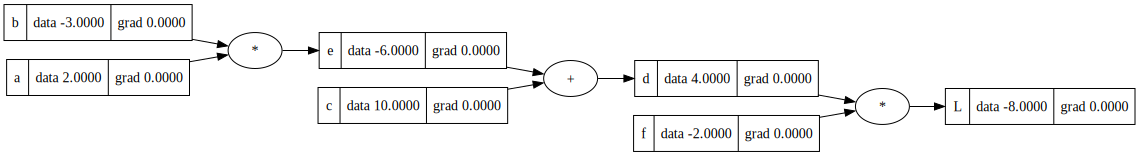

In [72]:
draw_dot(L)

In [84]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
    

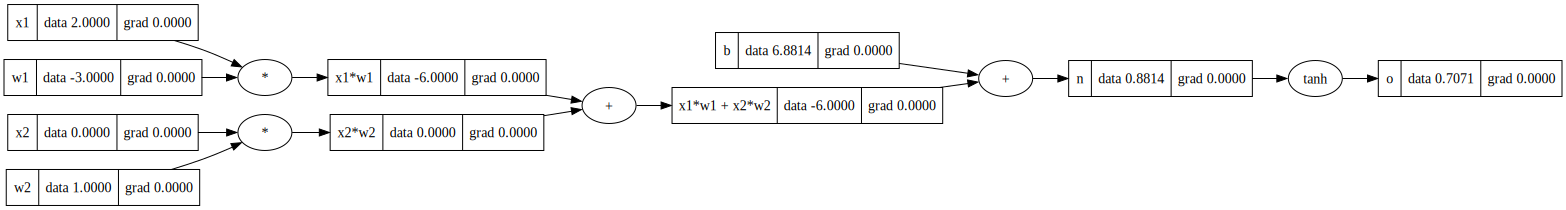

In [85]:
draw_dot(o)

Manual backpropagation

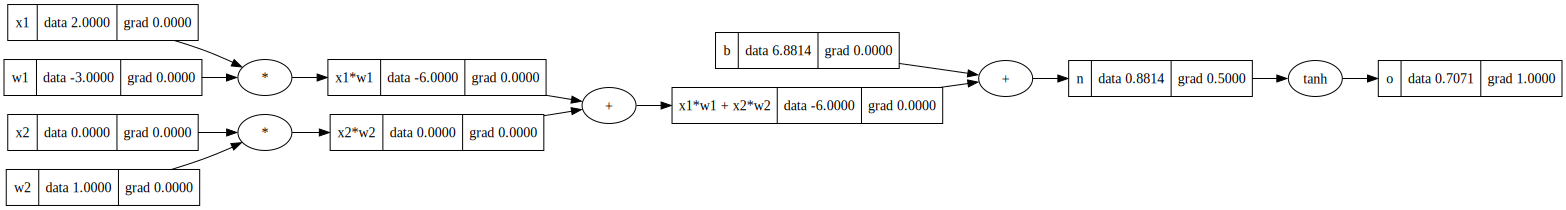

In [86]:
o.grad = 1.0
o._backward()
draw_dot(o)

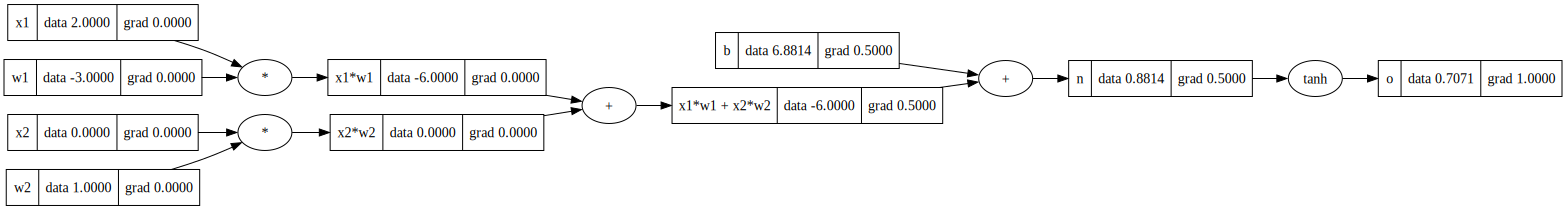

In [76]:
n._backward()
draw_dot(o)

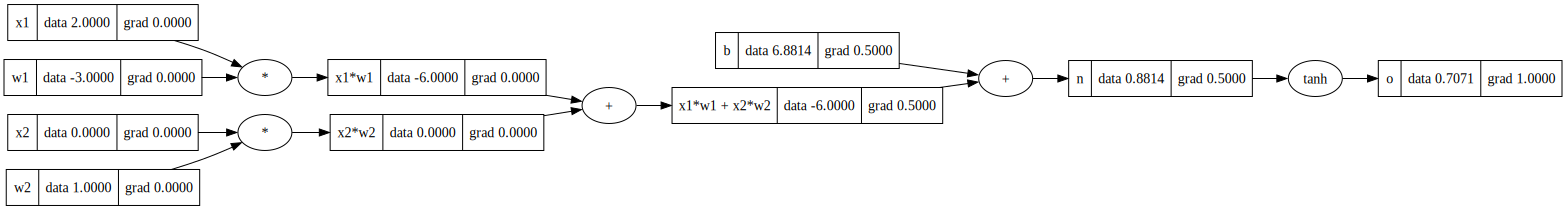

In [77]:
b._backward()
draw_dot(o)

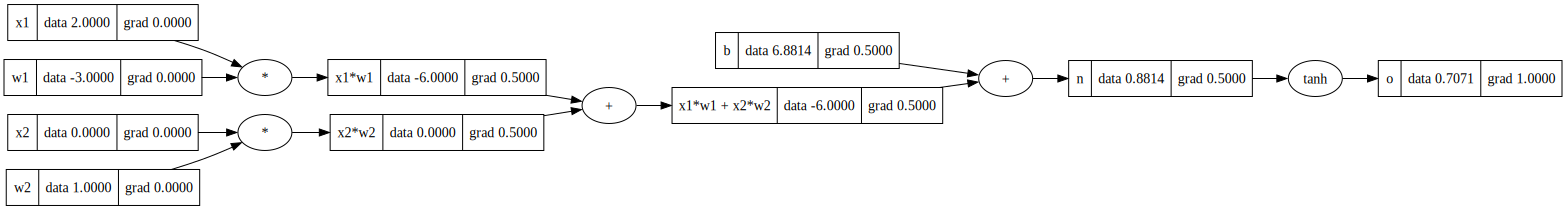

In [78]:
x1w1x2w2._backward()
draw_dot(o)

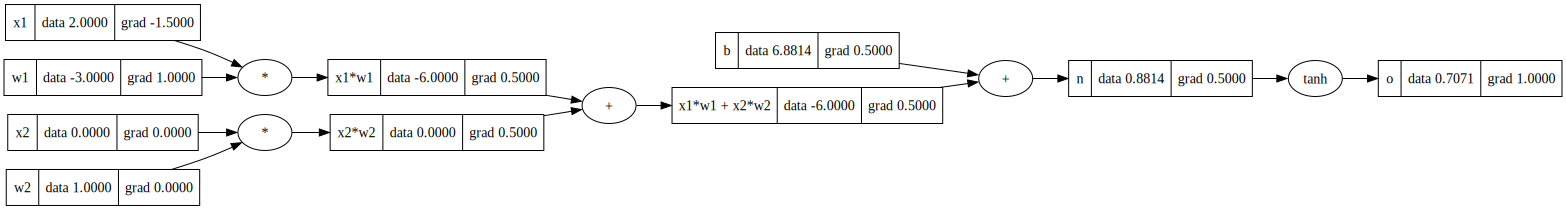

In [79]:
x1w1._backward()
draw_dot(o)

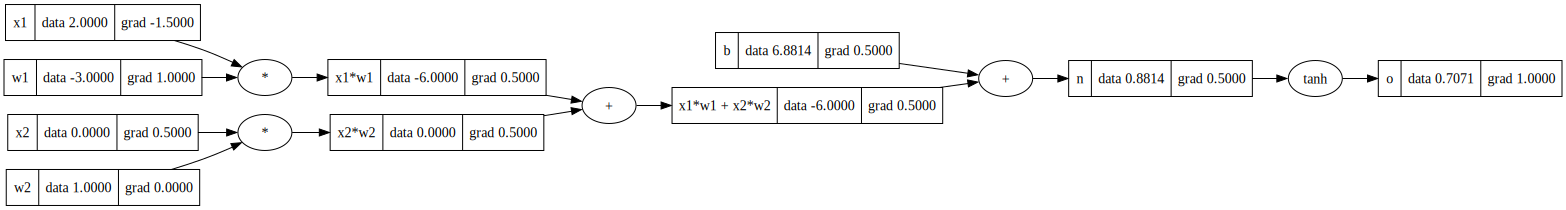

In [80]:
x2w2._backward()
draw_dot(o)

The above mannual process can be implemented using topological sort based on the compute graph.

The topological sort is a linear ordering of the nodes in a graph such that for every directed edge uv from node u to node v, u comes before v in the ordering.


In [81]:
# implement topological sort for the compute graph for backpropagation tracing starting at the end of the graph
# topological sort
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)
# backward from the output node
topological_sort(o)
for node in reversed(topo):
    node._backward()

In [82]:
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

After implement the topological in the Value class, we can simply call the backward() function to compute the gradient of the graph.

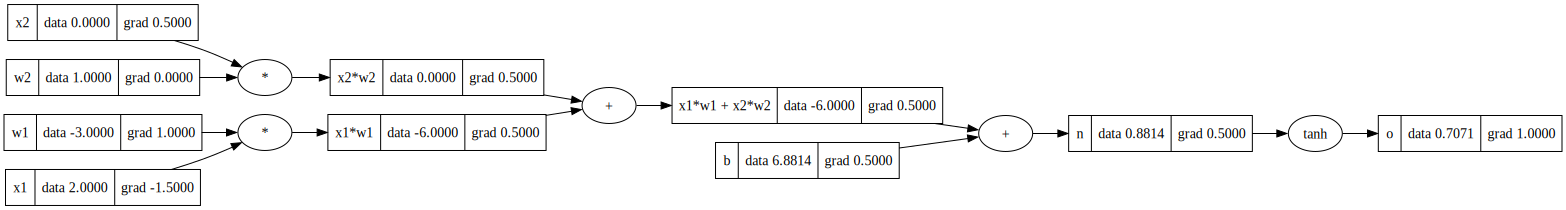

In [87]:
# reset the gradients
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# backward from the output node
o.grad = 1.0
o.backward()
draw_dot(o)

Try nonlinear function

In [91]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
a / b

Value(data=-0.6666666666666666)

In [94]:
# reset the gradients
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
## ====================
## tanh = (e^2x - 1) / (e^2x + 1)
e = (2*n).exp()
o = (e - 1) / (e + 1); 
## ===================
o.label = 'o'

In [ ]:
o.grad = 1.0
o.backward()
draw_dot(o)